In [172]:
import numpy as np
import dedalus.public as d3
import dedalus.core as d4
import logging
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline
import pathlib
import subprocess
import h5py
import glob
import re


In [ ]:
logger = logging.getLogger(__name__)


# Parameters
Lx, Lz = 4, 1
Nx, Nz = 256, 64
Md = 3
Rayleigh = 1e6
Vaisala= 4
Prandtl = 0.7
dealias = 3/2
QD=0
QM=QD/2
stop_sim_time = 50
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
d = dist.Field(name='d', bases=(xbasis,zbasis))
m = dist.Field(name='m', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
tau_p = dist.Field(name='tau_p')
tau_d1 = dist.Field(name='tau_d1', bases=xbasis)
tau_d2 = dist.Field(name='tau_d2', bases=xbasis)
tau_m1 = dist.Field(name='tau_m1', bases=xbasis)
tau_m2 = dist.Field(name='tau_m2', bases=xbasis)
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)
tau_c1 = dist.Field(name='tau_c1', bases=xbasis)
tau_c2 = dist.Field(name='tau_c2', bases=xbasis)

# Substitutions
kappa = (Lz**3*Md)/(Rayleigh * Prandtl)**(1/2)
nu = (Lz**3*Md)/(Rayleigh / Prandtl)**(1/2)
x, z = dist.local_grids(xbasis, zbasis)
ex, ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
grad_d = d3.grad(d) + ez*lift(tau_d1) # First-order reduction
grad_m = d3.grad(m) + ez*lift(tau_m1) # First-order reduction
ncc = dist.Field(name='ncc', bases=zbasis)
ncc['g'] = z
ncc.change_scales(3/2)

radiation = dist.Field(name='radiation', bases=zbasis)
radiation['g'] = np.sin(np.pi*z)

B = (m+d-Vaisala*ncc+np.absolute(m-d+Vaisala*ncc))/2
u_x = u @ ex
u_z = u @ ez
dz = lambda A: d3.Differentiate(A, coords['z'])
integ = lambda A: d3.Integrate(A, coords)
integ1= lambda A: d3.Integrate(A, coords)
Nusselt=1/7*dz(d3.Average(d,'x'))(z=0)-dz(d3.Average(m,'x'))(z=0)*2/7
dflux=d3.Average(u_z*d,('x','z'))
mflux=d3.Average(u_z*m,('x','z'))
bflux=d3.Average(u_z*B,('x','z'))
wflux=d3.Average(u_z*(2*m-d),('x','z'))

# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, d, m, u, tau_p, tau_d1, tau_d2, tau_m1, tau_m2, tau_u1, tau_u2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("dt(d) - kappa*div(grad_d) + lift(tau_d2) = - u@grad(d) - QD*radiation")
problem.add_equation("dt(m) - kappa*div(grad_m) + lift(tau_m2) = - u@grad(m) - QM*radiation")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p) + lift(tau_u2) = - u@grad(u)+ B*ez ")
problem.add_equation("d(z=0) = 0")
problem.add_equation("m(z=0) = 0")
problem.add_equation("d(z=Lz) = 1")
problem.add_equation("m(z=Lz) = -3")
problem.add_equation("u_z(z=0) = 0")
problem.add_equation("u_z(z=Lz) = 0")
problem.add_equation("dz(u_x)(z=0) = 0")
problem.add_equation("dz(u_x)(z=Lz)= 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Initial conditions
d.fill_random('g', seed=23, distribution='normal', scale=1e-3) # Random noise
d['g'] *= z * (Lz - z) # Damp noise at walls
d['g'] += z # Add linear background
m.fill_random('g', seed=41, distribution='normal', scale=1e-3) # Random noise
m['g'] *= z * (Lz - z) # Damp noise at walls
m['g'] += -3 * z # Add linear background

# Analysis
snapshots0 = solver.evaluator.add_file_handler('snapshots0', sim_dt=0.25, max_writes=50)
snapshots0.add_task(u, name='velocity')
snapshots0.add_task(d, name='dry buoyancy')
snapshots0.add_task(m, name='moist buoyancy')
snapshots0.add_task(B, name='buoyancy')
snapshots0.add_task(B-d+Vaisala*ncc, name='additional buoyancy')
snapshots0.add_task(-d3.div(d3.skew(u)), name='vorticity')
snapshots0.add_task(0.5*d3.dot(u,u), name='KE')
snapshots0.add_task(integ1(0.5*d3.dot(u,u)), name='total KE')
snapshots0.add_task(Nusselt, name='Nusselt')
snapshots0.add_task(dflux, name='dflux')
snapshots0.add_task(mflux, name='mflux')
snapshots0.add_task(bflux, name='bflux')
snapshots0.add_task(wflux, name='wflux')
snapshots0.add_task(d3.Average(d,('x',)), name='average dry buoyancy')
snapshots0.add_task(d3.Average(m,('x',)), name='average moist buoyancy')
snapshots0.add_task(d3.Average(B,('x',)), name='average buoyancy')

# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')

# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            #logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2023-07-11 18:06:38,316 subsystems 0/1 INFO :: Building subproblem matrices 1/128 (~1%) Elapsed: 0s, Remaining: 17s, Rate: 7.5e+00/s
2023-07-11 18:06:39,155 subsystems 0/1 INFO :: Building subproblem matrices 13/128 (~10%) Elapsed: 1s, Remaining: 9s, Rate: 1.3e+01/s
2023-07-11 18:06:40,065 subsystems 0/1 INFO :: Building subproblem matrices 26/128 (~20%) Elapsed: 2s, Remaining: 7s, Rate: 1.4e+01/s
2023-07-11 18:06:40,972 subsystems 0/1 INFO :: Building subproblem matrices 39/128 (~30%) Elapsed: 3s, Remaining: 6s, Rate: 1.4e+01/s
2023-07-11 18:06:41,876 subsystems 0/1 INFO :: Building subproblem matrices 52/128 (~41%) Elapsed: 4s, Remaining: 5s, Rate: 1.4e+01/s
2023-07-11 18:06:42,792 subsystems 0/1 INFO :: Building subproblem matrices 65/128 (~51%) Elapsed: 5s, Remaining: 4s, Rate: 1.4e+01/s
2023-07-11 18:06:43,702 subsystems 0/1 INFO :: Building subproblem matrices 78/128 (~61%) Elapsed: 6s, Remaining: 4s, Rate: 1.4e+01/s
2023-07-11 18:06:44,614 subsystems 0/1 INFO :: Building subprob

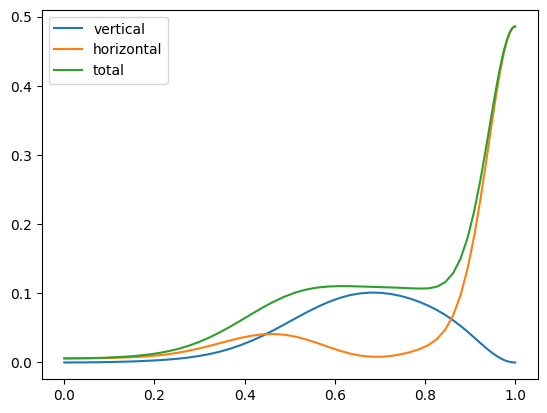

In [120]:
fig, ax = plt.subplots()

files = sorted(glob.glob('snapshots0/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    u=file['tasks']['velocity'][:]
    uz=u[:,1,:,:]
    ux=u[:,0,:,:]
    ax.plot(zgrid, np.mean((uz**2)[-1,:,:],axis=0),label='vertical')
    ax.plot(zgrid, np.mean((ux**2)[-1,:,:],axis=0),label='horizontal')
    ax.plot(zgrid, np.mean((uz**2+ux**2)[-1,:,:],axis=0),label='total')
    ax.legend()
    plt.show()

In [ ]:
fig, ax = plt.subplots()

files = sorted(glob.glob('snapshots0/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    dflux= file['tasks']['dflux'][:]
    mflux= file['tasks']['mflux'][:]
    bflux= file['tasks']['bflux']
    wflux= file['tasks']['wflux']
    print(dflux.shape)
    
ax.plot(zgrid, dflux[-1,0,0],label='dflux')
ax.plot(zgrid, mflux[-1,0,0],label='mflux')

In [96]:
np.mean(mflux)

0.04030119336256524

In [143]:
Nulsselt

1.5951890821537837

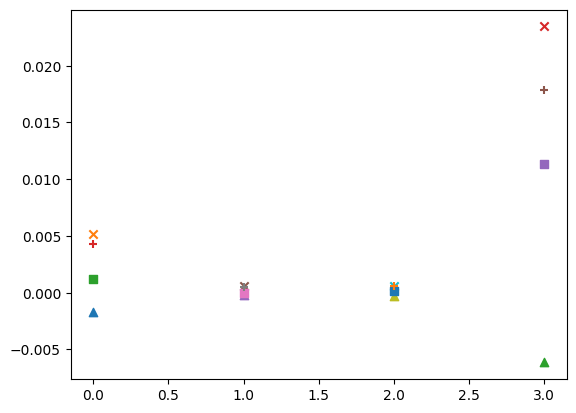

In [167]:
fix,ax=plt.subplots()
files = sorted(glob.glob('snapshots0/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    dflux= file['tasks']['dflux'][:]
    mflux= file['tasks']['mflux'][:]
    bflux= file['tasks']['bflux'][:]
    wflux= file['tasks']['wflux'][:]
    Nusselt= file['tasks']['Nusselt'][:]
    ax.scatter(0,np.mean(dflux),marker="^")
    ax.scatter(0,np.mean(mflux),marker="x")
    ax.scatter(0,np.mean(bflux),marker="s")
    ax.scatter(0,np.mean(wflux),marker="+")
    
files = sorted(glob.glob('snapshots1/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    dflux= file['tasks']['dflux'][:]
    mflux= file['tasks']['mflux'][:]
    bflux= file['tasks']['bflux'][:]
    wflux= file['tasks']['wflux'][:]
    Nusselt= file['tasks']['Nusselt'][:]
    ax.scatter(1,np.mean(dflux),marker="^")
    ax.scatter(1,np.mean(mflux),marker="x")
    ax.scatter(1,np.mean(bflux),marker="s")
    ax.scatter(1,np.mean(wflux),marker="+")
    
files = sorted(glob.glob('snapshots2/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    dflux= file['tasks']['dflux'][:]
    mflux= file['tasks']['mflux'][:]
    bflux= file['tasks']['bflux'][:]
    wflux= file['tasks']['wflux'][:]
    Nusselt= file['tasks']['Nusselt'][:]
    ax.scatter(2,np.mean(dflux),marker="^")
    ax.scatter(2,np.mean(mflux),marker="x")
    ax.scatter(2,np.mean(bflux),marker="s")
    ax.scatter(2,np.mean(wflux),marker="+")
    
files = sorted(glob.glob('snapshots3/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    dflux= file['tasks']['dflux'][:]
    mflux= file['tasks']['mflux'][:]
    bflux= file['tasks']['bflux'][:]
    wflux= file['tasks']['wflux'][:]
    Nusselt= file['tasks']['Nusselt'][:]
    ax.scatter(3,np.mean(dflux),marker="^")
    ax.scatter(3,np.mean(mflux),marker="x")
    ax.scatter(3,np.mean(bflux),marker="s")
    ax.scatter(3,np.mean(wflux),marker="+")
    
plt.show()


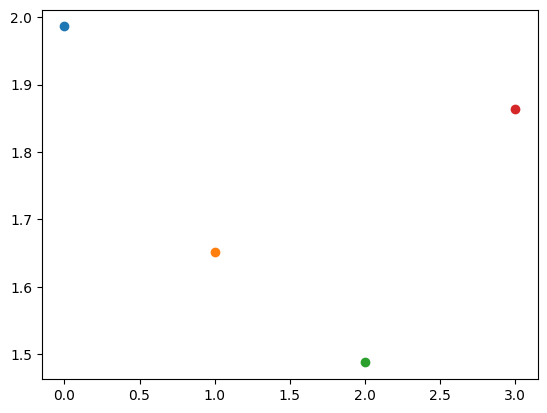

In [169]:
fix,ax=plt.subplots()
files = sorted(glob.glob('snapshots0/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    dflux= file['tasks']['dflux'][:]
    mflux= file['tasks']['mflux'][:]
    bflux= file['tasks']['bflux'][:]
    wflux= file['tasks']['wflux'][:]
    Nusselt= file['tasks']['Nusselt'][:]

    ax.scatter(0,np.mean(Nusselt[:,0,0]),marker="o")
    
files = sorted(glob.glob('snapshots1/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    dflux= file['tasks']['dflux'][:]
    mflux= file['tasks']['mflux'][:]
    bflux= file['tasks']['bflux'][:]
    wflux= file['tasks']['wflux'][:]
    Nusselt= file['tasks']['Nusselt'][:]

    ax.scatter(1,np.mean(Nusselt[:,0,0]),marker="o")
    
files = sorted(glob.glob('snapshots2/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    dflux= file['tasks']['dflux'][:]
    mflux= file['tasks']['mflux'][:]
    bflux= file['tasks']['bflux'][:]
    wflux= file['tasks']['wflux'][:]
    Nusselt= file['tasks']['Nusselt'][:]

    ax.scatter(2,np.mean(Nusselt[:,0,0]),marker="o")
    
files = sorted(glob.glob('snapshots3/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    dflux= file['tasks']['dflux'][:]
    mflux= file['tasks']['mflux'][:]
    bflux= file['tasks']['bflux'][:]
    wflux= file['tasks']['wflux'][:]
    Nusselt= file['tasks']['Nusselt'][:]

    ax.scatter(3,np.mean(Nusselt[:,0,0]),marker="o")
    
plt.show()


In [ ]:
logger = logging.getLogger(__name__)


# Parameters
Lx, Lz = 4, 1
Nx, Nz = 256, 64
Md = 3
Rayleigh = 1e6
Vaisala= 4
Prandtl = 0.7
dealias = 3/2
QD=0.0028
QM=QD/2
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
d = dist.Field(name='d', bases=(xbasis,zbasis))
m = dist.Field(name='m', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
tau_p = dist.Field(name='tau_p')
tau_d1 = dist.Field(name='tau_d1', bases=xbasis)
tau_d2 = dist.Field(name='tau_d2', bases=xbasis)
tau_m1 = dist.Field(name='tau_m1', bases=xbasis)
tau_m2 = dist.Field(name='tau_m2', bases=xbasis)
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)
tau_c1 = dist.Field(name='tau_c1', bases=xbasis)
tau_c2 = dist.Field(name='tau_c2', bases=xbasis)

# Substitutions
kappa = (Lz**3*Md)/(Rayleigh * Prandtl)**(1/2)
nu = (Lz**3*Md)/(Rayleigh / Prandtl)**(1/2)
x, z = dist.local_grids(xbasis, zbasis)
ex, ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
grad_d = d3.grad(d) + ez*lift(tau_d1) # First-order reduction
grad_m = d3.grad(m) + ez*lift(tau_m1) # First-order reduction
ncc = dist.Field(name='ncc', bases=zbasis)
ncc['g'] = z
ncc.change_scales(3/2)

radiation = dist.Field(name='radiation', bases=zbasis)
radiation['g'] = np.sin(np.pi*z)

B = (m+d-Vaisala*ncc+np.absolute(m-d+Vaisala*ncc))/2
u_x = u @ ex
u_z = u @ ez
dz = lambda A: d3.Differentiate(A, coords['z'])
integ = lambda A: d3.Integrate(A, coords)
integ1= lambda A: d3.Integrate(A, coords)
Nusselt=1/7*dz(d3.Average(d,'x'))(z=0)-dz(d3.Average(m,'x'))(z=0)*2/7
dflux=d3.Average(u_z*d,('x','z'))
mflux=d3.Average(u_z*m,('x','z'))
bflux=d3.Average(u_z*B,('x','z'))
wflux=d3.Average(u_z*(2*m-d),('x','z'))

# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, d, m, u, tau_p, tau_d1, tau_d2, tau_m1, tau_m2, tau_u1, tau_u2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("dt(d) - kappa*div(grad_d) + lift(tau_d2) = - u@grad(d) - QD*radiation")
problem.add_equation("dt(m) - kappa*div(grad_m) + lift(tau_m2) = - u@grad(m) - QM*radiation")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p) + lift(tau_u2) = - u@grad(u)+ B*ez ")
problem.add_equation("d(z=0) = 0")
problem.add_equation("m(z=0) = 0")
problem.add_equation("d(z=Lz) = 1")
problem.add_equation("m(z=Lz) = -3")
problem.add_equation("u_z(z=0) = 0")
problem.add_equation("u_z(z=Lz) = 0")
problem.add_equation("dz(u_x)(z=0) = 0")
problem.add_equation("dz(u_x)(z=Lz)= 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Initial conditions
d.fill_random('g', seed=23, distribution='normal', scale=1e-3) # Random noise
d['g'] *= z * (Lz - z) # Damp noise at walls
d['g'] += z # Add linear background
m.fill_random('g', seed=41, distribution='normal', scale=1e-3) # Random noise
m['g'] *= z * (Lz - z) # Damp noise at walls
m['g'] += -3 * z # Add linear background

# Analysis
snapshots1 = solver.evaluator.add_file_handler('snapshots1', sim_dt=0.25, max_writes=50)
snapshots1.add_task(u, name='velocity')
snapshots1.add_task(d, name='dry buoyancy')
snapshots1.add_task(m, name='moist buoyancy')
snapshots1.add_task(B, name='buoyancy')
snapshots1.add_task(B-d+Vaisala*ncc, name='additional buoyancy')
snapshots1.add_task(-d3.div(d3.skew(u)), name='vorticity')
snapshots1.add_task(0.5*d3.dot(u,u), name='KE')
snapshots1.add_task(integ1(0.5*d3.dot(u,u)), name='total KE')
snapshots1.add_task(Nusselt, name='Nusselt')
snapshots1.add_task(dflux, name='dflux')
snapshots1.add_task(mflux, name='mflux')
snapshots1.add_task(bflux, name='bflux')
snapshots1.add_task(wflux, name='wflux')
snapshots1.add_task(d3.Average(d,('x',)), name='average dry buoyancy')
snapshots1.add_task(d3.Average(m,('x',)), name='average moist buoyancy')
snapshots1.add_task(d3.Average(B,('x',)), name='average buoyancy')

# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')

# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            #logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

KeyError: "Unable to open object (object 'radiation' doesn't exist)"

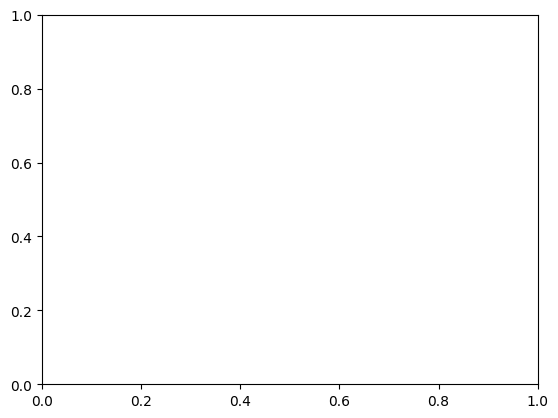

In [157]:
files = sorted(glob.glob('snapshots1/*.h5'),key=lambda f: int(re.sub('\D', '', f)))
fix,ax=plt.subplots()

with h5py.File(files[1], mode='r') as file:
    R= file['tasks']['radiation']
    Ra= file['tasks']['radiation'][:]
    zgrid=R.dims[2][0][:]

ax.plot(zgrid, QD*Ra[-1,0,:],label='dry Radiation')
ax.plot(zgrid, QM*Ra[-1,0,:],label='moist Radiation')
plt.legend()
plt.show()

In [ ]:
logger = logging.getLogger(__name__)


# Parameters
Lx, Lz = 4, 1
Nx, Nz = 256, 64
Md = 3
Rayleigh = 1e6
Vaisala= 4
Prandtl = 0.7
dealias = 3/2
QD=0.014
QM=QD/2
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
d = dist.Field(name='d', bases=(xbasis,zbasis))
m = dist.Field(name='m', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
tau_p = dist.Field(name='tau_p')
tau_d1 = dist.Field(name='tau_d1', bases=xbasis)
tau_d2 = dist.Field(name='tau_d2', bases=xbasis)
tau_m1 = dist.Field(name='tau_m1', bases=xbasis)
tau_m2 = dist.Field(name='tau_m2', bases=xbasis)
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)
tau_c1 = dist.Field(name='tau_c1', bases=xbasis)
tau_c2 = dist.Field(name='tau_c2', bases=xbasis)

# Substitutions
kappa = (Lz**3*Md)/(Rayleigh * Prandtl)**(1/2)
nu = (Lz**3*Md)/(Rayleigh / Prandtl)**(1/2)
x, z = dist.local_grids(xbasis, zbasis)
ex, ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
grad_d = d3.grad(d) + ez*lift(tau_d1) # First-order reduction
grad_m = d3.grad(m) + ez*lift(tau_m1) # First-order reduction
ncc = dist.Field(name='ncc', bases=zbasis)
ncc['g'] = z
ncc.change_scales(3/2)

radiation = dist.Field(name='radiation', bases=zbasis)
radiation['g'] = np.sin(np.pi*z)

B = (m+d-Vaisala*ncc+np.absolute(m-d+Vaisala*ncc))/2
u_x = u @ ex
u_z = u @ ez
dz = lambda A: d3.Differentiate(A, coords['z'])
integ = lambda A: d3.Integrate(A, coords)
integ1= lambda A: d3.Integrate(A, coords)
Nusselt=1/7*dz(d3.Average(d,'x'))(z=0)-dz(d3.Average(m,'x'))(z=0)*2/7
dflux=d3.Average(u_z*d,('x','z'))
mflux=d3.Average(u_z*m,('x','z'))
bflux=d3.Average(u_z*B,('x','z'))
wflux=d3.Average(u_z*(2*m-d),('x','z'))

# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, d, m, u, tau_p, tau_d1, tau_d2, tau_m1, tau_m2, tau_u1, tau_u2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("dt(d) - kappa*div(grad_d) + lift(tau_d2) = - u@grad(d) - QD*radiation")
problem.add_equation("dt(m) - kappa*div(grad_m) + lift(tau_m2) = - u@grad(m) - QM*radiation")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p) + lift(tau_u2) = - u@grad(u)+ B*ez ")
problem.add_equation("d(z=0) = 0")
problem.add_equation("m(z=0) = 0")
problem.add_equation("d(z=Lz) = 1")
problem.add_equation("m(z=Lz) = -3")
problem.add_equation("u_z(z=0) = 0")
problem.add_equation("u_z(z=Lz) = 0")
problem.add_equation("dz(u_x)(z=0) = 0")
problem.add_equation("dz(u_x)(z=Lz)= 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Initial conditions
d.fill_random('g', seed=23, distribution='normal', scale=1e-3) # Random noise
d['g'] *= z * (Lz - z) # Damp noise at walls
d['g'] += z # Add linear background
m.fill_random('g', seed=41, distribution='normal', scale=1e-3) # Random noise
m['g'] *= z * (Lz - z) # Damp noise at walls
m['g'] += -3 * z # Add linear background

# Analysis
snapshots2 = solver.evaluator.add_file_handler('snapshots2', sim_dt=0.25, max_writes=50)
snapshots2.add_task(u, name='velocity')
snapshots2.add_task(d, name='dry buoyancy')
snapshots2.add_task(m, name='moist buoyancy')
snapshots2.add_task(B, name='buoyancy')
snapshots2.add_task(B-d+Vaisala*ncc, name='additional buoyancy')
snapshots2.add_task(-d3.div(d3.skew(u)), name='vorticity')
snapshots2.add_task(0.5*d3.dot(u,u), name='KE')
snapshots2.add_task(integ1(0.5*d3.dot(u,u)), name='total KE')
snapshots2.add_task(Nusselt, name='Nusselt')
snapshots2.add_task(dflux, name='dflux')
snapshots2.add_task(mflux, name='mflux')
snapshots2.add_task(bflux, name='bflux')
snapshots2.add_task(wflux, name='wflux')
snapshots2.add_task(d3.Average(d,('x',)), name='average dry buoyancy')
snapshots2.add_task(d3.Average(m,('x',)), name='average moist buoyancy')
snapshots2.add_task(d3.Average(B,('x',)), name='average buoyancy')


# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')

# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            #logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

In [ ]:
#0.028

logger = logging.getLogger(__name__)


# Parameters
Lx, Lz = 4, 1
Nx, Nz = 256, 64
Md = 3
Rayleigh = 1e6
Vaisala= 4
Prandtl = 0.7
dealias = 3/2
QD=0.07
QM=QD/2
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

# Bases
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

# Fields
p = dist.Field(name='p', bases=(xbasis,zbasis))
d = dist.Field(name='d', bases=(xbasis,zbasis))
m = dist.Field(name='m', bases=(xbasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,zbasis))
tau_p = dist.Field(name='tau_p')
tau_d1 = dist.Field(name='tau_d1', bases=xbasis)
tau_d2 = dist.Field(name='tau_d2', bases=xbasis)
tau_m1 = dist.Field(name='tau_m1', bases=xbasis)
tau_m2 = dist.Field(name='tau_m2', bases=xbasis)
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis)
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis)
tau_c1 = dist.Field(name='tau_c1', bases=xbasis)
tau_c2 = dist.Field(name='tau_c2', bases=xbasis)

# Substitutions
kappa = (Lz**3*Md)/(Rayleigh * Prandtl)**(1/2)
nu = (Lz**3*Md)/(Rayleigh / Prandtl)**(1/2)
x, z = dist.local_grids(xbasis, zbasis)
ex, ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)
grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
grad_d = d3.grad(d) + ez*lift(tau_d1) # First-order reduction
grad_m = d3.grad(m) + ez*lift(tau_m1) # First-order reduction
ncc = dist.Field(name='ncc', bases=zbasis)
ncc['g'] = z
ncc.change_scales(3/2)

radiation = dist.Field(name='radiation', bases=zbasis)
radiation['g'] = np.sin(np.pi*z)

B = (m+d-Vaisala*ncc+np.absolute(m-d+Vaisala*ncc))/2
u_x = u @ ex
u_z = u @ ez
dz = lambda A: d3.Differentiate(A, coords['z'])
integ = lambda A: d3.Integrate(A, coords)
integ1= lambda A: d3.Integrate(A, coords)
Nusselt=1/7*dz(d3.Average(d,'x'))(z=0)-dz(d3.Average(m,'x'))(z=0)*2/7
dflux=d3.Average(u_z*d,('x','z'))
mflux=d3.Average(u_z*m,('x','z'))
bflux=d3.Average(u_z*B,('x','z'))
wflux=d3.Average(u_z*(2*m-d),('x','z'))

# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, d, m, u, tau_p, tau_d1, tau_d2, tau_m1, tau_m2, tau_u1, tau_u2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("dt(d) - kappa*div(grad_d) + lift(tau_d2) = - u@grad(d) - QD*radiation")
problem.add_equation("dt(m) - kappa*div(grad_m) + lift(tau_m2) = - u@grad(m) - QM*radiation")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p) + lift(tau_u2) = - u@grad(u)+ B*ez ")
problem.add_equation("d(z=0) = 0")
problem.add_equation("m(z=0) = 0")
problem.add_equation("d(z=Lz) = 1")
problem.add_equation("m(z=Lz) = -3")
problem.add_equation("u_z(z=0) = 0")
problem.add_equation("u_z(z=Lz) = 0")
problem.add_equation("dz(u_x)(z=0) = 0")
problem.add_equation("dz(u_x)(z=Lz)= 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

# Initial conditions
d.fill_random('g', seed=23, distribution='normal', scale=1e-3) # Random noise
d['g'] *= z * (Lz - z) # Damp noise at walls
d['g'] += z # Add linear background
m.fill_random('g', seed=41, distribution='normal', scale=1e-3) # Random noise
m['g'] *= z * (Lz - z) # Damp noise at walls
m['g'] += -3 * z # Add linear background

# Analysis
snapshots3 = solver.evaluator.add_file_handler('snapshots3', sim_dt=0.25, max_writes=50)
snapshots3.add_task(u, name='velocity')
snapshots3.add_task(d, name='dry buoyancy')
snapshots3.add_task(m, name='moist buoyancy')
snapshots3.add_task(B, name='buoyancy')
snapshots3.add_task(B-d+Vaisala*ncc, name='additional buoyancy')
snapshots3.add_task(-d3.div(d3.skew(u)), name='vorticity')
snapshots3.add_task(0.5*d3.dot(u,u), name='KE')
snapshots3.add_task(integ1(0.5*d3.dot(u,u)), name='total KE')
snapshots3.add_task(Nusselt, name='Nusselt')
snapshots3.add_task(dflux, name='dflux')
snapshots3.add_task(mflux, name='mflux')
snapshots3.add_task(bflux, name='bflux')
snapshots3.add_task(wflux, name='wflux')
snapshots3.add_task(d3.Average(d,('x',)), name='average dry buoyancy')
snapshots3.add_task(d3.Average(m,('x',)), name='average moist buoyancy')
snapshots3.add_task(d3.Average(B,('x',)), name='average buoyancy')


# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')

# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            #logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()


In [ ]:
files = sorted(glob.glob('snapshots0/*.h5'),key=lambda f: int(re.sub('\D', '', f)))
fig, ax = plt.subplots()

with h5py.File(files[0], mode='r') as file:
    KEs0 = file['tasks']['total KE'][:,:,:]
    
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        KE = file['tasks']['total KE'][:,:,:]
        KEs0=np.append(KEs0,KE,axis=0)

ax.plot(np.arange(len(KEs0[:,0,0]))/4*nu, KEs0[:,0,0],label='Q=0')

files = sorted(glob.glob('snapshots1/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[0], mode='r') as file:
    KEs1 = file['tasks']['total KE'][:,:,:]
    
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        KE = file['tasks']['total KE'][:,:,:]
        KEs1=np.append(KEs1,KE,axis=0)

ax.plot(np.arange(len(KEs1[:,0,0]))/4*nu, KEs1[:,0,0],linestyle='dotted',label='Q=0.0028')

files = sorted(glob.glob('snapshots2/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[0], mode='r') as file:
    KEs2 = file['tasks']['total KE'][:,:,:]
    
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        KE = file['tasks']['total KE'][:,:,:]
        KEs2=np.append(KEs2,KE,axis=0)

ax.plot(np.arange(len(KEs2[:,0,0]))/4*nu, KEs2[:,0,0],linestyle='--',label='Q=0.014')
        
files = sorted(glob.glob('snapshots3/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[0], mode='r') as file:
    KEs3 = file['tasks']['total KE'][:,:,:]
    
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        KE = file['tasks']['total KE'][:,:,:]
        KEs3=np.append(KEs3,KE,axis=0)

ax.plot(np.arange(len(KEs3[:,0,0]))/4*nu, KEs3[:,0,0], linestyle='dashdot', label='Q=0.07')

ax.set_title('Total KE vs Time')
ax.grid(True)
ax.set_xlabel(r"Normalized Time $\nu t/H^2$")
ax.set_ylabel(r"Total KE  $\log_{10}E_k(t)$")
ax.set_yscale('log')
plt.legend()

plt.savefig('Total_KE_vs_Time')

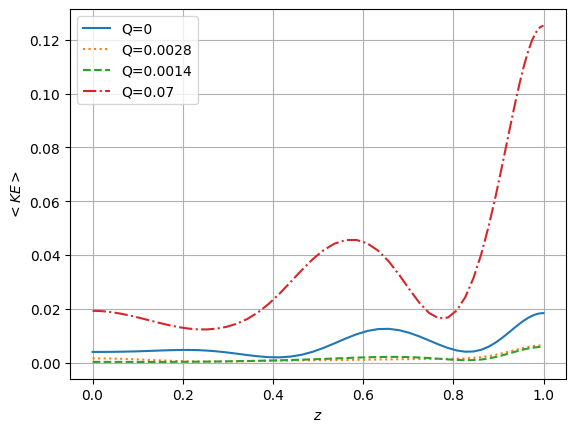

In [165]:
fig, ax = plt.subplots()

files = sorted(glob.glob('snapshots0/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-2], mode='r') as file:
    KE1 = file['tasks']['KE']
    xgrid=KE1.dims[1][0][:]
    zgrid=KE1.dims[2][0][:]
    KE = file['tasks']['KE'][-1,:,:]
    avgKE=np.mean(KE,axis=0)
    
ax.plot(zgrid, avgKE,label='Q=0')

files = sorted(glob.glob('snapshots1/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-2], mode='r') as file:
    KE1 = file['tasks']['KE']
    xgrid=KE1.dims[1][0][:]
    zgrid=KE1.dims[2][0][:]
    KE = file['tasks']['KE'][-1,:,:]
    avgKE=np.mean(KE,axis=0)
    
ax.plot(zgrid, avgKE,label='Q=0.0028',linestyle='dotted')

files = sorted(glob.glob('snapshots2/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-2], mode='r') as file:
    KE1 = file['tasks']['KE']
    xgrid=KE1.dims[1][0][:]
    zgrid=KE1.dims[2][0][:]
    KE = file['tasks']['KE'][-1,:,:]
    avgKE=np.mean(KE,axis=0)
    
ax.plot(zgrid, avgKE,label='Q=0.0014',linestyle='--',)

files = sorted(glob.glob('snapshots3/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-2], mode='r') as file:
    KE1 = file['tasks']['KE']
    xgrid=KE1.dims[1][0][:]
    zgrid=KE1.dims[2][0][:]
    KE = file['tasks']['KE'][-1,:,:]
    avgKE=np.mean(KE,axis=0)
    
ax.plot(zgrid, avgKE,label='Q=0.07',linestyle='dashdot')
ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$<KE>$")
ax.grid(True)
plt.legend()
plt.show()

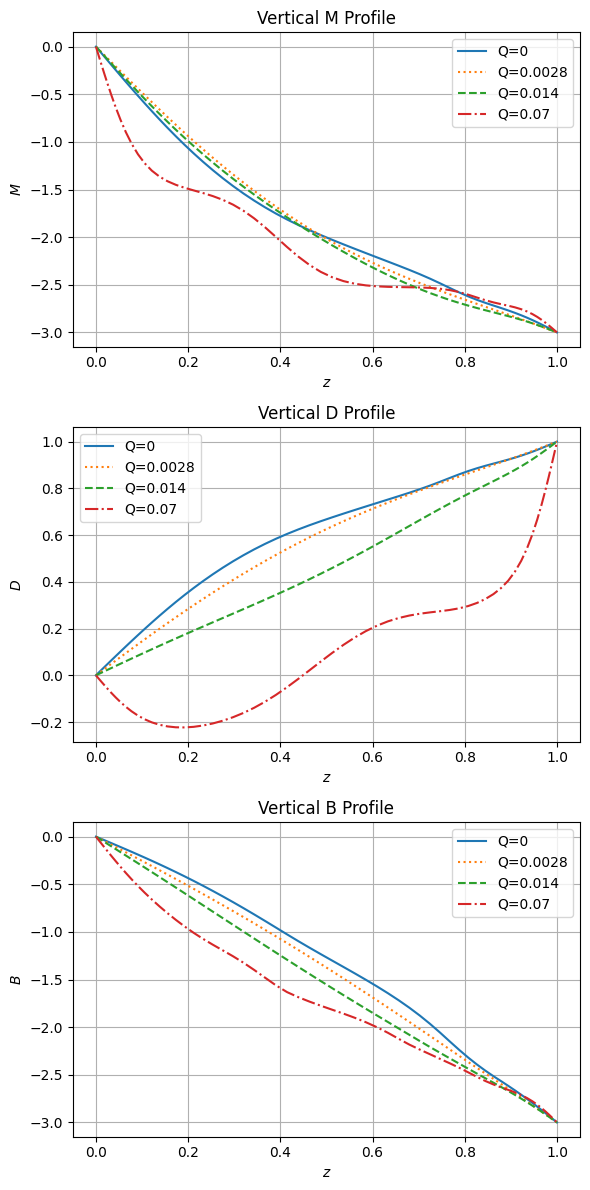

In [166]:
fig, ax = plt.subplots(3, figsize=(6,12))

#M
files = sorted(glob.glob('snapshots0/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy']
    xgrid=moist_buoyancy.dims[1][0][:]
    zgrid=moist_buoyancy.dims[2][0][:]
    dry_buoyancy = file['tasks']['dry buoyancy'][:,:,:]
    moist_buoyancy = file['tasks']['moist buoyancy'][:,:,:]
    buoyancy = file['tasks']['buoyancy'][:,:,:]
    avgmbs=np.mean(moist_buoyancy,axis=1)
    avgdbs=np.mean(dry_buoyancy,axis=1)
    avgbs=np.mean(buoyancy,axis=1)
    
ax[0].plot(zgrid, avgmbs[-1,:],label='Q=0')
ax[1].plot(zgrid, avgdbs[-1,:],label='Q=0')
ax[2].plot(zgrid, avgbs[-1,:],label='Q=0')

#M
files = sorted(glob.glob('snapshots1/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy']
    xgrid=moist_buoyancy.dims[1][0][:]
    zgrid=moist_buoyancy.dims[2][0][:]
    dry_buoyancy = file['tasks']['dry buoyancy'][:,:,:]
    moist_buoyancy = file['tasks']['moist buoyancy'][:,:,:]
    buoyancy = file['tasks']['buoyancy'][:,:,:]
    avgmbs=np.mean(moist_buoyancy,axis=1)
    avgdbs=np.mean(dry_buoyancy,axis=1)
    avgbs=np.mean(buoyancy,axis=1)
    
ax[0].plot(zgrid, avgmbs[-1,:],linestyle='dotted',label='Q=0.0028')
ax[1].plot(zgrid, avgdbs[-1,:],linestyle='dotted',label='Q=0.0028')
ax[2].plot(zgrid, avgbs[-1,:],linestyle='dotted',label='Q=0.0028')

#M
files = sorted(glob.glob('snapshots2/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy']
    xgrid=moist_buoyancy.dims[1][0][:]
    zgrid=moist_buoyancy.dims[2][0][:]
    dry_buoyancy = file['tasks']['dry buoyancy'][:,:,:]
    moist_buoyancy = file['tasks']['moist buoyancy'][:,:,:]
    buoyancy = file['tasks']['buoyancy'][:,:,:]
    avgmbs=np.mean(moist_buoyancy,axis=1)
    avgdbs=np.mean(dry_buoyancy,axis=1)
    avgbs=np.mean(buoyancy,axis=1)
    
ax[0].plot(zgrid, avgmbs[-1,:],linestyle='--',label='Q=0.014')
ax[1].plot(zgrid, avgdbs[-1,:],linestyle='--',label='Q=0.014')
ax[2].plot(zgrid, avgbs[-1,:],linestyle='--',label='Q=0.014')

#M
files = sorted(glob.glob('snapshots3/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy']
    xgrid=moist_buoyancy.dims[1][0][:]
    zgrid=moist_buoyancy.dims[2][0][:]
    dry_buoyancy = file['tasks']['dry buoyancy'][:,:,:]
    moist_buoyancy = file['tasks']['moist buoyancy'][:,:,:]
    buoyancy = file['tasks']['buoyancy'][:,:,:]
    avgmbs=np.mean(moist_buoyancy,axis=1)
    avgdbs=np.mean(dry_buoyancy,axis=1)
    avgbs=np.mean(buoyancy,axis=1)
    
ax[0].plot(zgrid, avgmbs[-1,:],linestyle='dashdot',label='Q=0.07')
ax[1].plot(zgrid, avgdbs[-1,:],linestyle='dashdot',label='Q=0.07')
ax[2].plot(zgrid, avgbs[-1,:],linestyle='dashdot',label='Q=0.07')

ax[0].set_title('Vertical M Profile')
ax[0].grid(True)
ax[0].set_xlabel(r"$z$")
ax[0].set_ylabel(r"$M$")
ax[0].legend()

ax[1].set_title('Vertical D Profile')
ax[1].grid(True)
ax[1].set_xlabel(r"$z$")
ax[1].set_ylabel(r"$D$")
ax[1].legend()

ax[2].set_title('Vertical B Profile')
ax[2].grid(True)
ax[2].set_xlabel(r"$z$")
ax[2].set_ylabel(r"$B$")
ax[2].legend()

plt.tight_layout()
plt.savefig('Vertical Profile')
plt.show()

In [ ]:
with h5py.File(files[0], mode='r') as file:
    KEs0 = file['tasks']['total KE'][:,:,:]
    
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        KE = file['tasks']['total KE'][:,:,:]
        KEs0=np.append(KEs0,KE,axis=0)


(64,)


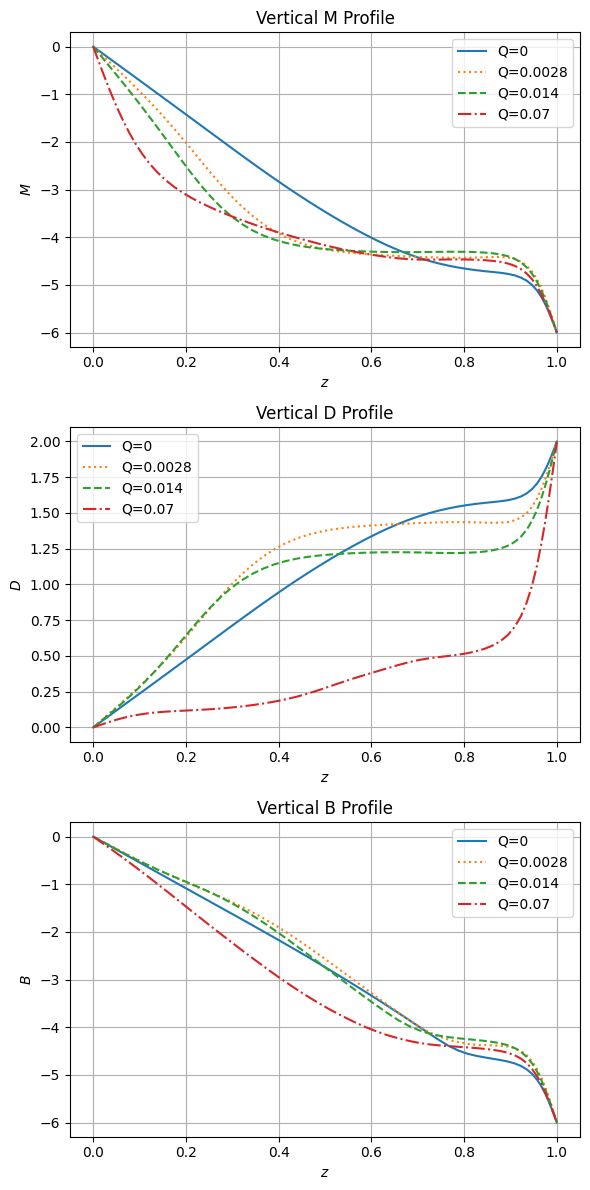

In [37]:
fig, ax = plt.subplots(3, figsize=(6,12))

#M
files = sorted(glob.glob('snapshots0/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[0], mode='r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy']
    xgrid=moist_buoyancy.dims[1][0][:]
    zgrid=moist_buoyancy.dims[2][0][:]
    dry_buoyancy = file['tasks']['dry buoyancy'][:,:,:]
    moist_buoyancy = file['tasks']['moist buoyancy'][:,:,:]
    buoyancy = file['tasks']['buoyancy'][:,:,:]
    avgmbs=np.mean(moist_buoyancy,axis=1)
    avgdbs=np.mean(dry_buoyancy,axis=1)
    avgbs=np.mean(buoyancy,axis=1)
    avgmbs1=np.mean(avgmbs,axis=0)
    avgdbs1=np.mean(avgdbs,axis=0)
    avgbs1=np.mean(avgbs,axis=0)
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        moist_buoyancy = file['tasks']['moist buoyancy']
        xgrid=moist_buoyancy.dims[1][0][:]
        zgrid=moist_buoyancy.dims[2][0][:]
        dry_buoyancy = file['tasks']['dry buoyancy'][:,:,:]
        moist_buoyancy = file['tasks']['moist buoyancy'][:,:,:]
        buoyancy = file['tasks']['buoyancy'][:,:,:]
        avgmbs=np.mean(moist_buoyancy,axis=1)
        avgdbs=np.mean(dry_buoyancy,axis=1)
        avgbs=np.mean(buoyancy,axis=1)
        avgmbs2=np.mean(avgmbs,axis=0)
        avgdbs2=np.mean(avgdbs,axis=0)
        avgbs2=np.mean(avgbs,axis=0)
        avgmbs1+=avgmbs2
        avgdbs1+=avgdbs2
        avgbs1+=avgbs2

    
ax[0].plot(zgrid, avgmbs1[:],label='Q=0')
ax[1].plot(zgrid, avgdbs1[:],label='Q=0')
ax[2].plot(zgrid, avgbs1[:],label='Q=0')

#M
files = sorted(glob.glob('snapshots1/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy']
    xgrid=moist_buoyancy.dims[1][0][:]
    zgrid=moist_buoyancy.dims[2][0][:]
    dry_buoyancy = file['tasks']['dry buoyancy'][:,:,:]
    moist_buoyancy = file['tasks']['moist buoyancy'][:,:,:]
    buoyancy = file['tasks']['buoyancy'][:,:,:]
    avgmbs=np.mean(moist_buoyancy,axis=1)
    avgdbs=np.mean(dry_buoyancy,axis=1)
    avgbs=np.mean(buoyancy,axis=1)
    avgmbs1=np.mean(avgmbs,axis=0)
    avgdbs1=np.mean(avgdbs,axis=0)
    avgbs1=np.mean(avgbs,axis=0)  
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        moist_buoyancy = file['tasks']['moist buoyancy']
        xgrid=moist_buoyancy.dims[1][0][:]
        zgrid=moist_buoyancy.dims[2][0][:]
        dry_buoyancy = file['tasks']['dry buoyancy'][:,:,:]
        moist_buoyancy = file['tasks']['moist buoyancy'][:,:,:]
        buoyancy = file['tasks']['buoyancy'][:,:,:]
        avgmbs=np.mean(moist_buoyancy,axis=1)
        avgdbs=np.mean(dry_buoyancy,axis=1)
        avgbs=np.mean(buoyancy,axis=1)
        avgmbs2=np.mean(avgmbs,axis=0)
        avgdbs2=np.mean(avgdbs,axis=0)
        avgbs2=np.mean(avgbs,axis=0)
        avgmbs1+=avgmbs2
        avgdbs1+=avgdbs2
        avgbs1+=avgbs2
        
ax[0].plot(zgrid, avgmbs1[:],linestyle='dotted',label='Q=0.0028')
ax[1].plot(zgrid, avgdbs1[:],linestyle='dotted',label='Q=0.0028')
ax[2].plot(zgrid, avgbs1[:],linestyle='dotted',label='Q=0.0028')

#M
files = sorted(glob.glob('snapshots2/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy']
    xgrid=moist_buoyancy.dims[1][0][:]
    zgrid=moist_buoyancy.dims[2][0][:]
    dry_buoyancy = file['tasks']['dry buoyancy'][:,:,:]
    moist_buoyancy = file['tasks']['moist buoyancy'][:,:,:]
    buoyancy = file['tasks']['buoyancy'][:,:,:]
    avgmbs=np.mean(moist_buoyancy,axis=1)
    avgdbs=np.mean(dry_buoyancy,axis=1)
    avgbs=np.mean(buoyancy,axis=1)
    avgmbs1=np.mean(avgmbs,axis=0)
    avgdbs1=np.mean(avgdbs,axis=0)
    avgbs1=np.mean(avgbs,axis=0)
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        moist_buoyancy = file['tasks']['moist buoyancy']
        xgrid=moist_buoyancy.dims[1][0][:]
        zgrid=moist_buoyancy.dims[2][0][:]
        dry_buoyancy = file['tasks']['dry buoyancy'][:,:,:]
        moist_buoyancy = file['tasks']['moist buoyancy'][:,:,:]
        buoyancy = file['tasks']['buoyancy'][:,:,:]
        avgmbs=np.mean(moist_buoyancy,axis=1)
        avgdbs=np.mean(dry_buoyancy,axis=1)
        avgbs=np.mean(buoyancy,axis=1)
        avgmbs2=np.mean(avgmbs,axis=0)
        avgdbs2=np.mean(avgdbs,axis=0)
        avgbs2=np.mean(avgbs,axis=0)
        avgmbs1+=avgmbs2
        avgdbs1+=avgdbs2
        avgbs1+=avgbs2
        
ax[0].plot(zgrid, avgmbs1[:],linestyle='--',label='Q=0.014')
ax[1].plot(zgrid, avgdbs1[:],linestyle='--',label='Q=0.014')
ax[2].plot(zgrid, avgbs1[:],linestyle='--',label='Q=0.014')

#M
files = sorted(glob.glob('snapshots3/*.h5'),key=lambda f: int(re.sub('\D', '', f)))

with h5py.File(files[-1], mode='r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy']
    xgrid=moist_buoyancy.dims[1][0][:]
    zgrid=moist_buoyancy.dims[2][0][:]
    dry_buoyancy = file['tasks']['dry buoyancy'][:,:,:]
    moist_buoyancy = file['tasks']['moist buoyancy'][:,:,:]
    buoyancy = file['tasks']['buoyancy'][:,:,:]
    avgmbs=np.mean(moist_buoyancy,axis=1)
    avgdbs=np.mean(dry_buoyancy,axis=1)
    avgbs=np.mean(buoyancy,axis=1)
    avgmbs1=np.mean(avgmbs,axis=0)
    avgdbs1=np.mean(avgdbs,axis=0)
    avgbs1=np.mean(avgbs,axis=0)
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        moist_buoyancy = file['tasks']['moist buoyancy']
        xgrid=moist_buoyancy.dims[1][0][:]
        zgrid=moist_buoyancy.dims[2][0][:]
        dry_buoyancy = file['tasks']['dry buoyancy'][:,:,:]
        moist_buoyancy = file['tasks']['moist buoyancy'][:,:,:]
        buoyancy = file['tasks']['buoyancy'][:,:,:]
        avgmbs=np.mean(moist_buoyancy,axis=1)
        avgdbs=np.mean(dry_buoyancy,axis=1)
        avgbs=np.mean(buoyancy,axis=1)
        avgmbs2=np.mean(avgmbs,axis=0)
        avgdbs2=np.mean(avgdbs,axis=0)
        avgbs2=np.mean(avgbs,axis=0)
        avgmbs1+=avgmbs2
        avgdbs1+=avgdbs2
        avgbs1+=avgbs2
        
ax[0].plot(zgrid, avgmbs1[:],linestyle='dashdot',label='Q=0.07')
ax[1].plot(zgrid, avgdbs1[:],linestyle='dashdot',label='Q=0.07')
ax[2].plot(zgrid, avgbs1[:],linestyle='dashdot',label='Q=0.07')

ax[0].set_title('Vertical M Profile')
ax[0].grid(True)
ax[0].set_xlabel(r"$z$")
ax[0].set_ylabel(r"$M$")
ax[0].legend()

ax[1].set_title('Vertical D Profile')
ax[1].grid(True)
ax[1].set_xlabel(r"$z$")
ax[1].set_ylabel(r"$D$")
ax[1].legend()

ax[2].set_title('Vertical B Profile')
ax[2].grid(True)
ax[2].set_xlabel(r"$z$")
ax[2].set_ylabel(r"$B$")
ax[2].legend()

plt.tight_layout()
plt.savefig('Vertical Profile Time Average')
plt.show()

finished processing
2023-06-28 16:46:57,030 matplotlib.animation 0/1 WARNING :: MovieWriter imagemagick unavailable; using Pillow instead.
2023-06-28 16:46:57,032 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.PillowWriter'>


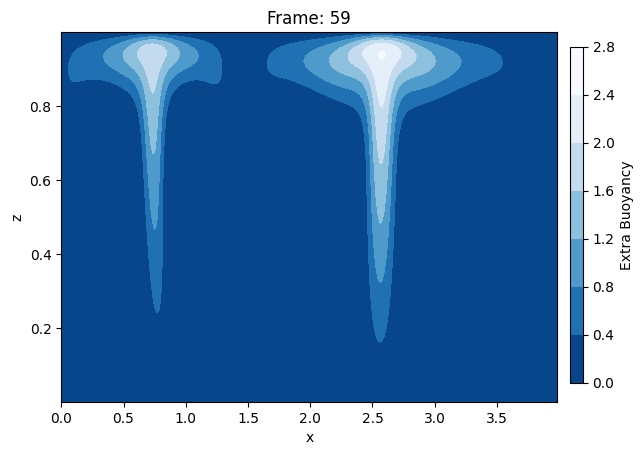

In [278]:
files = sorted(glob.glob('snapshots0/*.h5'),key=lambda f: int(re.sub('\D', '', f)))
with h5py.File(files[0], mode='r') as file:
    moist_buoyancy = file['tasks']['moist buoyancy']
    dry_buoyancy = file['tasks']['dry buoyancy']
    xgrid=moist_buoyancy.dims[1][0][:]
    zgrid=moist_buoyancy.dims[2][0][:]
    buoyancy=np.maximum(moist_buoyancy[:, :, :],dry_buoyancy[:, :, :]-Vaisala*zgrid)
    clouds=buoyancy-(dry_buoyancy[:, :, :]-Vaisala*zgrid)
for i in range(1,len(files)):
    with h5py.File(files[i], mode='r') as file:
        moist_buoyancy = file['tasks']['moist buoyancy']
        dry_buoyancy = file['tasks']['dry buoyancy']
        buoyancy=np.maximum(moist_buoyancy[:, :, :],dry_buoyancy[:, :, :]-Vaisala*zgrid)
        cloud=buoyancy-(dry_buoyancy[:, :, :]-Vaisala*zgrid)
        clouds=np.append(clouds,cloud,axis=0)
        
clouds = np.where(clouds < 0, 0, clouds)     
global_min=np.min(clouds) 
global_max=np.max(clouds)
conditon = (clouds == global_max)
max_pos = np.where(conditon)
print("finished processing")
fig, ax = plt.subplots()
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Define colorbar axes position
img = ax.contourf(xgrid, zgrid, clouds[int(max_pos[0]), :, :].T, vmin=global_min, vmax=global_max,cmap='Blues_r' )
cb = fig.colorbar(img, cax=cax)
cb.set_label('Extra Buoyancy')

def animate(frame):
    ax.clear()
    img = ax.contourf(xgrid,zgrid,clouds[frame, :, :].T, vmin=global_min, vmax=global_max,cmap='Blues_r')
    ax.set_title('Frame: {}'.format(frame))
    ax.set_xlabel('x')  # Add x-axis label
    ax.set_ylabel('z')  # Add y-axis label

# Call animate method
animation = FuncAnimation(fig, animate, frames=len(clouds), interval=100, blit=False)
animation.save('delete.gif', writer='imagemagick')
# Display the plot
plt.show()